In [1]:
import getpass
import os
import sys
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from typing import Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from py2neo import Graph
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

from pathlib import Path
project_root = Path(r"F:\bigmodel\meet-Pok-mon\4.KGqa\Pokemon-KGQA").resolve()
sys.path.insert(0, str(project_root))
from NER.ner_model import *
from RAG.langchaingraph.query import GraphRAG

f:\Anaconda\envs\pokemon\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = r"F:\bigmodel\meet-Pok-mon\4.KGqa\Pokemon-KGQA"
model_base_path = "F:/bigmodel/models/"  # 模型和权重的基础路径
model_name = os.path.join(model_base_path, "chinese-roberta-wwm-ext")
pt_path = os.path.join(model_name, "best_roberta.pt")

In [3]:
class EntityRecognition:
    def __init__(self):
        # 初始化规则和 TF-IDF 对齐
        self.rule = rule_find()
        self.tfidf_r = tfidf_alignment()

        # 加载 tag2idx
        if os.path.exists('tag2idx.npy'):
            with open('tag2idx.npy', 'rb') as f:
                self.tag2idx = pickle.load(f)
                self.idx2tag = list(self.tag2idx)
        else:
            raise FileNotFoundError("tag2idx文件不存在！")

        # 初始化设备
        self.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

        # 加载 tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=model_base_path)

        # 初始化模型
        hidden_size = 128
        bi = True
        self.model = Bert_Model(model_name, hidden_size, len(self.tag2idx), bi)

        # 加载模型权重
        if os.path.exists(pt_path):
            print("加载已有模型")
            self.model.load_state_dict(torch.load(pt_path, map_location=self.device))
        else:
            raise FileNotFoundError("未找到模型权重文件!!")

        # 将模型移动到设备
        self.model = self.model.to(self.device)

        print('模型初始化完成 ......')

    def ner(self, question):
        # 调用 NER 方法
        return get_ner_result(self.model, self.tokenizer, question, self.rule, self.tfidf_r, self.device, self.idx2tag)

In [4]:
EnR = EntityRecognition()

加载已有模型
模型初始化完成 ......


In [5]:
# llm = ChatOllama(
#     base_url = "127.0.0.1:11434",  # 注意：这里需要替换成自己本地启动的endpoint
#     model="qwen2.5:7b",
# )
llm = ChatOpenAI(
    model="deepseek-v3-0324",  # 模型名称（需与后端匹配）
    base_url="http://139.224.116.116:3000/v1",  # 本地或远程 API 地址
    api_key="sk-36oMlDApF5Nlg0v23014A4B69e864000944151Cd75D82076"  # 如果无需鉴权，可留空
)

In [6]:
g = Graph("bolt://localhost:7687", auth=("neo4j", "woshishamo630"))

In [7]:
class AgentState(MessagesState):
    next: str

In [8]:
def chat(state: AgentState):
    messages = state["messages"]
    model_response = llm.invoke(messages)
    # final_response = [HumanMessage(content=model_response.content, name="chatbot")]
    return {"messages": model_response}

In [9]:
class PokemonQuery(BaseModel):
    pokemon: str

class PersonQuery(BaseModel):
    person: str

class TownQuery(BaseModel):
    town: str

class RegionQuery(BaseModel):
    region: str

class IdentityQuery(BaseModel):
    identity: str
    
class Entity(BaseModel):
    question: str


# 宝可梦相关查询
@tool(args_schema=PokemonQuery)
def get_pokemon_chinese_name(pokemon: str):
    """查询宝可梦的中文名"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.name AS chinese_name;"
    return execute_query(sql, "chinese_name", f"未找到宝可梦: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_english_name(pokemon: str):
    """查询宝可梦的英文名"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.english_name AS english_name;"
    return execute_query(sql, "english_name", f"未找到宝可梦的英文名: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_ability(pokemon: str):
    """查询宝可梦的特性"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.ability AS ability;"
    return execute_query(sql, "ability", f"未找到宝可梦特性: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_hidden_ability(pokemon: str):
    """查询宝可梦的隐藏特性"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.hidden_ability AS hidden_ability;"
    return execute_query(sql, "hidden_ability", f"未找到宝可梦隐藏特性: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_height(pokemon: str):
    """查询宝可梦的身高"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.height AS height;"
    return execute_query(sql, "height", f"未找到宝可梦身高: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_weight(pokemon: str):
    """查询宝可梦的体重"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.weight AS weight;"
    return execute_query(sql, "weight", f"未找到宝可梦体重: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_evolution_level(pokemon: str):
    """查询宝可梦的进化等级"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.evolution_level AS evolution_level;"
    return execute_query(sql, "evolution_level", f"未找到宝可梦进化等级: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_attributes(pokemon: str):
    """查询宝可梦的属性抗性"""
    sql = f"MATCH (p:Pokémon) WHERE p.name = '{pokemon}' RETURN p.attr_ability AS attr_ability;"
    return execute_query(sql, "attr_ability", f"未找到宝可梦属性抗性: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_evolution(pokemon: str):
    """查询宝可梦的进化形态"""
    sql = f"MATCH (p1:Pokémon)-[:evolves_into]->(p2:Pokémon) WHERE p1.name = '{pokemon}' RETURN p2.name AS evolution_name;"
    return execute_query(sql, "evolution_name", f"未找到宝可梦进化形态: {pokemon}")

@tool(args_schema=PokemonQuery)
def get_pokemon_types(pokemon: str):
    """查询宝可梦的属性"""
    sql = f"MATCH (p:Pokémon)-[:has_type]->(i:identity) WHERE p.name = '{pokemon}' RETURN COLLECT(i.name) AS types;"
    return execute_query(sql, "types", f"未找到宝可梦属性: {pokemon}")

# 人物相关查询
@tool(args_schema=PersonQuery)
def get_person_gender(person: str):
    """查询人物性别"""
    sql = f"MATCH (per:Person) WHERE per.name = '{person}' RETURN per.gender AS gender;"
    return execute_query(sql, "gender", f"未找到人物性别: {person}")

@tool(args_schema=PersonQuery)
def get_person_english_name(person: str):
    """查询人物英文名"""
    sql = f"MATCH (per:Person) WHERE per.name = '{person}' RETURN per.english_name AS english_name;"
    return execute_query(sql, "english_name", f"未找到人物英文名: {person}")

@tool(args_schema=PersonQuery)
def get_person_japanese_name(person: str):
    """查询人物日本名"""
    sql = f"MATCH (per:Person) WHERE per.name = '{person}' RETURN per.japanese_name AS japanese_name;"
    return execute_query(sql, "japanese_name", f"未找到人物日本名: {person}")

@tool(args_schema=PersonQuery)
def get_person_challengers(person: str):
    """查询人物的挑战者"""
    sql = f"MATCH (per1:Person)-[:challenge]->(per2:Person) WHERE per1.name = '{person}' RETURN COLLECT(per2.name) AS challengers;"
    return execute_query(sql, "challengers", f"未找到人物挑战者: {person}")

@tool(args_schema=PersonQuery)
def get_person_partners(person: str):
    """查询人物的伙伴"""
    sql = f"MATCH (per1:Person)-[:partner]->(per2:Person) WHERE per1.name = '{person}' RETURN COLLECT(per2.name) AS partners;"
    return execute_query(sql, "partners", f"未找到人物伙伴: {person}")

@tool(args_schema=PersonQuery)
def get_person_enemies(person: str):
    """查询人物的敌对者"""
    sql = f"MATCH (per1:Person)-[:hostility]->(per2:Person) WHERE per1.name = '{person}' RETURN COLLECT(per2.name) AS enemies;"
    return execute_query(sql, "enemies", f"未找到人物敌对者: {person}")

@tool(args_schema=PersonQuery)
def get_person_relatives(person: str):
    """查询人物的亲戚"""
    sql = f"MATCH (per1:Person)-[:relative]->(per2:Person) WHERE per1.name = '{person}' RETURN COLLECT(per2.name) AS relatives;"
    return execute_query(sql, "relatives", f"未找到人物亲戚: {person}")

# 地区、城镇相关查询
@tool(args_schema=TownQuery)
def get_town_region(town: str):
    """查询城镇所在的地区"""
    sql = f"MATCH (t:Town)-[:located_in]->(r:Region) WHERE t.name = '{town}' RETURN r.name AS region;"
    return execute_query(sql, "region", f"未找到城镇所在地区: {town}")

@tool(args_schema=RegionQuery)
def get_region_towns(region: str):
    """查询地区的城镇"""
    sql = f"MATCH (r:Region)<-[:located_in]-(t:Town) WHERE r.name = '{region}' RETURN COLLECT(t.name) AS towns;"
    return execute_query(sql, "towns", f"未找到地区城镇: {region}")

@tool(args_schema=PersonQuery)
def get_person_hometown(person: str):
    """查询人物来自哪个地区"""
    sql = f"MATCH (per:Person)-[:come_from]->(r:Region) WHERE per.name = '{person}' RETURN r.name AS region;"
    return execute_query(sql, "region", f"未找到人物家乡: {person}")

@tool(args_schema=RegionQuery)
def get_region_people(region: str):
    """查询地区有哪些人物"""
    sql = f"MATCH (per:Person)-[:come_from]->(r:Region) WHERE r.name = '{region}' RETURN COLLECT(per.name) AS people;"
    return execute_query(sql, "people", f"未找到地区人物: {region}")

# 人物与宝可梦关系查询
@tool(args_schema=PersonQuery)
def get_person_pokemons(person: str):
    """查询人物拥有哪些宝可梦"""
    sql = f"MATCH (per:Person)-[:has_pokemon]->(p:Pokémon) WHERE per.name = '{person}' RETURN COLLECT(p.name) AS pokemons;"
    return execute_query(sql, "pokemons", f"未找到人物拥有的宝可梦: {person}")

@tool(args_schema=PokemonQuery)
def get_pokemon_owners(pokemon: str):
    """查询拥有某个宝可梦的人物"""
    sql = f"MATCH (per:Person)-[:has_pokemon]->(p:Pokémon) WHERE p.name = '{pokemon}' RETURN COLLECT(per.name) AS owners;"
    return execute_query(sql, "owners", f"未找到宝可梦的拥有者: {pokemon}")

# 城镇与宝可梦关系查询
@tool(args_schema=TownQuery)
def get_town_pokemons(town: str):
    """查询城镇有哪些宝可梦"""
    sql = f"MATCH (t:Town)-[:location_pokemon]->(p:Pokémon) WHERE t.name = '{town}' RETURN COLLECT(p.name) AS pokemons;"
    return execute_query(sql, "pokemons", f"未找到城镇的宝可梦: {town}")

@tool(args_schema=PokemonQuery)
def get_pokemon_towns(pokemon: str):
    """查询哪些城镇有某个宝可梦"""
    sql = f"MATCH (t:Town)-[:location_pokemon]->(p:Pokémon) WHERE p.name = '{pokemon}' RETURN COLLECT(t.name) AS towns;"
    return execute_query(sql, "towns", f"未找到宝可梦出现的城镇: {pokemon}")

# 城镇与人物关系查询
@tool(args_schema=TownQuery)
def get_town_people(town: str):
    """查询城镇有哪些人物"""
    sql = f"MATCH (t:Town)-[:has_celebrity]->(per:Person) WHERE t.name = '{town}' RETURN COLLECT(per.name) AS people;"
    return execute_query(sql, "people", f"未找到城镇人物: {town}")

@tool(args_schema=PersonQuery)
def get_person_town(person: str):
    """查询人物来自哪个城镇"""
    sql = f"MATCH (per:Person)-[:come_from]->(t:Town) WHERE per.name = '{person}' RETURN t.name AS town;"
    return execute_query(sql, "town", f"未找到人物所在城镇: {person}")

# 统计查询
@tool(args_schema=RegionQuery)
def count_region_towns(region: str):
    """查询某个地区有多少城镇"""
    sql = f"MATCH (r:Region)<-[:located_in]-(t:Town) WHERE r.name = '{region}' RETURN COUNT(t) AS count;"
    return execute_query(sql, "count", f"未找到地区城镇数量: {region}")

@tool(args_schema=TownQuery)
def count_town_pokemons(town: str):
    """查询某个城镇有多少宝可梦"""
    sql = f"MATCH (t:Town)-[:location_pokemon]->(p:Pokémon) WHERE t.name = '{town}' RETURN COUNT(p) AS count;"
    return execute_query(sql, "count", f"未找到城镇宝可梦数量: {town}")

@tool(args_schema=PersonQuery)
def count_person_pokemons(person: str):
    """查询人物拥有多少宝可梦"""
    sql = f"MATCH (per:Person)-[:has_pokemon]->(p:Pokémon) WHERE per.name = '{person}' RETURN COUNT(p) AS count;"
    return execute_query(sql, "count", f"未找到人物宝可梦数量: {person}")

@tool(args_schema=PokemonQuery)
def count_pokemon_types(pokemon: str):
    """查询宝可梦有多少种属性"""
    sql = f"MATCH (p:Pokémon)-[:has_type]->(i:identity) WHERE p.name = '{pokemon}' RETURN COUNT(i) AS count;"
    return execute_query(sql, "count", f"未找到宝可梦属性数量: {pokemon}")

# 属性相关查询
@tool(args_schema=IdentityQuery)
def get_pokemons_by_type(identity: str):
    """查询某个属性的宝可梦有哪些"""
    sql = f"MATCH (p:Pokémon)-[:has_type]->(i:identity) WHERE i.name = '{identity}' RETURN COLLECT(p.name) AS pokemons;"
    return execute_query(sql, "pokemons", f"未找到该属性的宝可梦: {identity}")

# 实体匹配
@tool(args_schema=Entity)
def get_entity(question: str):
    """你必须调用这个工具，且只调用一次，对于用户的输入进行实体匹配，且后续查询的参数需在返回的实体中选择"""
    return EnR.ner(question)


def execute_query(sql: str, result_key: str, not_found_msg: str):
    """执行Neo4j查询并返回格式化结果"""
    try:
        result = g.run(sql).data()
        if result:
            # 处理单条结果和列表结果
            if isinstance(result[0].get(result_key), list):
                return {result_key: result[0][result_key]}
            return {result_key: result[0][result_key]}
        return {"message": not_found_msg}
    except Exception as e:
        return {"error": f"查询失败: {str(e)}", "sql": sql}

    
tools = [
    get_pokemon_chinese_name,
    get_pokemon_english_name,
    get_pokemon_ability,
    get_pokemon_hidden_ability,
    get_pokemon_height,
    get_pokemon_weight,
    get_pokemon_evolution_level,
    get_pokemon_attributes,
    get_pokemon_evolution,
    get_pokemon_types,
    get_person_gender,
    get_person_english_name,
    get_person_japanese_name,
    get_person_challengers,
    get_person_partners,
    get_person_enemies,
    get_person_relatives,
    get_town_region,
    get_region_towns,
    get_person_hometown,
    get_region_people,
    get_person_pokemons,
    get_pokemon_owners,
    get_town_pokemons,
    get_pokemon_towns,
    get_town_people,
    get_person_town,
    count_region_towns,
    count_town_pokemons,
    count_person_pokemons,
    count_pokemon_types,
    get_pokemons_by_type,
    get_entity
]

In [10]:
kgsql_agent = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier="当用户询问关于宝可梦、人物、城镇、地区、属性的相关信息时，你将使用这些函数来查询neo4j数据库中的数据"
)

In [54]:
def print_stream(stream):
    for sub_stream in stream:
        print(sub_stream)  # 就是上面的示例中非流式直接调用的全部信息
input_message = {"messages": ["拥有皮卡丘的角色中，哪些是小刚的朋友？"]}
print_stream(kgsql_agent.stream(input_message, stream_mode="updates"))

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a6zt8h6efa3yt6hzddz1pkxu', 'function': {'arguments': '{"question":"拥有皮卡丘的角色中，哪些是小刚的朋友？"}', 'name': 'get_entity'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 2599, 'total_tokens': 2629, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'deepseek/deepseek-v3-0324', 'system_fingerprint': '', 'id': '0217435836893706773b021bc722319529820bd350d49415a6df8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-282241f0-8cb6-4a53-8615-6c7eea370608-0', tool_calls=[{'name': 'get_entity', 'args': {'question': '拥有皮卡丘的角色中，哪些是小刚的朋友？'}, 'id': 'call_a6zt8h6efa3yt6hzddz1pkxu', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2599, 'output_tokens': 30, 'tot

In [12]:
def kgsql_node(state: AgentState):
    result = kgsql_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="kg_sqler")
        ]
    }


In [13]:
# 配置参数
graph_rag_config = {
    "artifacts_path": "F:\\bigmodel\\meet-Pok-mon\\4.KGqa\\Pokemon-KGQA\\RAG\\artifacts",
    "llm_config": {
        "model": "deepseek-v3-0324",
        "base_url": "http://139.224.116.116:3000/v1",
        "api_key": "sk-36oMlDApF5Nlg0v23014A4B69e864000944151Cd75D82076"
    },
    "community_level": 0
}

# 初始化GraphRAG系统
graph_rag = GraphRAG(
    artifacts_path=graph_rag_config["artifacts_path"],
    llm_config=graph_rag_config["llm_config"],
    community_level=graph_rag_config["community_level"]
)

In [35]:
def graph_rager(state: AgentState):
    messages = state["messages"]

    response = graph_rag.query(messages) 
    final_response = [HumanMessage(content=response.content, name="graph_rager")]
    return {"messages": final_response}

In [36]:
#构建代理节点
members = ["chat","kg_sqler","graph_rager"]
options = members + ["FINISH"]

In [37]:
# class Router(TypedDict):
#     """Worker to route to next. If no workers needed, route to FINISH"""

#     next: Literal[*options] # type: ignore
    
# 创建提示模板
prompt = ChatPromptTemplate.from_template("""
请严格按以下JSON格式回复，只包含next字段，值必须是'chat'或'kg_sqler'或'graph_rager'或'FINISH'：

{{
    "next": "FINISH"
}}

输入：{input}
""")

In [44]:
def supervisor(state: AgentState):
    system_prompt = (
        "你被指定为对话监督员，负责协调以下工作模块的协作：{members}\n\n"
        "各模块职能划分：\n"
        "- chat：自然语言交互模块\n"
            "  • 直接处理用户输入的自然语言响应\n"
        "- kg_sqler：宝可梦知识图谱查询模块\n"
            "  • 属性数据（种族值/进化链/特性）\n"
            "  • 角色关系（训练师/劲敌/团队）\n"
            "  • 地域情报（地点/道馆/栖息地）\n"
        "- graph_rager：宝可梦相关知识库\n"
            "  • 人物介绍（如人物事迹等）\n"
            "  • 社群发现（如道馆派系识别）\n"
            "  • 路径分析（角色关联路径追踪）\n"
            "  • 时序关联（赛事参与时间轴分析）\n\n"
        "请根据用户请求指定下一个执行模块。"
        "每个模块执行后将返回任务结果及状态。\n"
        "执行流程规范：\n"
        "1. chat模块最多能调用一次\n"
        "2. 你可以不断调用上述的模块，当某个模块的结果不足以回答用户的问题时（如未查询到相关结果），你可以继续调用其他模块，直到用户问题得到回答。"
        "3. 当你任务完成时，才能返回FINISH终止符"
)

    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    chain = prompt | llm | JsonOutputParser()
    response = chain.invoke({"input": messages})

    next_ = response["next"]
    
    if next_ == "FINISH":
        next_ = END
    
    return {"next": next_}

In [45]:
builder = StateGraph(AgentState)

builder.add_node("supervisor", supervisor)
builder.add_node("chat", chat)
builder.add_node("kg_sqler", kgsql_node)
builder.add_node("graph_rager", graph_rager)

In [46]:
for member in members:
    # 我们希望我们的工人在完成工作后总是向主管“汇报”
    builder.add_edge(member, "supervisor")

In [47]:
#添加supervisor的条件边
builder.add_conditional_edges("supervisor", lambda state: state["next"])
# 添加开始和节点
builder.add_edge(START, "supervisor")
#增加检查点
memory = MemorySaver()
# 编译图
graph = builder.compile(checkpointer=memory)

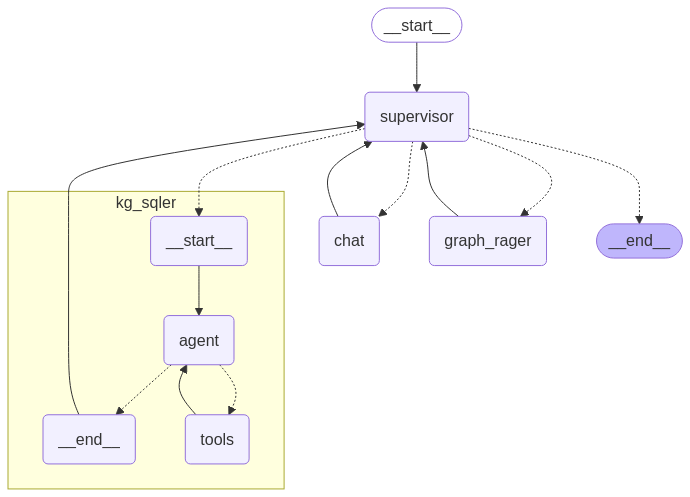

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [49]:
config = {"configurable": {"thread_id": "4"}}
def print_stream(stream):
    for sub_stream in stream:
        print(sub_stream)  # 就是上面的示例中非流式直接调用的全部信息
input_message = {"messages": ["恭平有哪些宝可梦？"]}
print_stream(graph.stream(input_message, config, stream_mode="updates"))

# input_message = {"messages": ["你好，请问我刚刚问你关于皮卡丘的什么了？"]}
# print_stream(graph.stream(input_message, config, stream_mode="updates"))

{'supervisor': {'next': 'kg_sqler'}}
{'kg_sqler': {'messages': [HumanMessage(content='我无法找到与“恭平”相关的信息。请确认名字是否正确，或者提供更多背景信息以便我更好地帮助您。', additional_kwargs={}, response_metadata={}, name='kg_sqler', id='dad91364-c462-4f41-8f91-9e799fb328ab')]}}


Reached max tokens for a community report call ...
Reached max tokens for a community report call ...
Reached max tokens for a community report call ...


{'supervisor': {'next': 'graph_rager'}}
{'graph_rager': {'messages': [HumanMessage(content='# 恭平的宝可梦队伍分析\n\n## 核心宝可梦阵容\n\n根据现有信息，恭平的主要宝可梦队伍包括以下成员：\n\n- **呱呱泡蛙/呱头蛙**：最初因与母亲分离而充满负面情绪，但在训练中坚持不懈最终进化。与猛火猴有着深厚的合作关系。\n- **木守宫**：以冷静和战术灵活性著称，经常与呱呱泡蛙一起训练和战斗。\n- **妖火红狐**：队伍核心之一，拥有强大的火焰能力和智慧，不仅保护恭平还照顾其他精灵。\n- **猛火猴**：与呱头蛙并肩作战，并在战斗后帮助其恢复。\n- **花洁夫人**：队伍中的治疗者，擅长保护色和花瓣舞等技能，为其他精灵提供支援。\n- **触手百合/摇篮百合**：来自研究所的基因复制实验品，进化后成为对抗强大对手的关键战力。\n- **尼多王**：来自关东地区的地面/毒属性宝可梦，攻击力强且与触手百合配合紧密。\n\n## 其他重要宝可梦\n\n- **巨沼怪**：电磁曾将巨沼怪超进化石赠予恭平，表明其在队伍中可能扮演重要角色。\n- **急冻鸟**：与恭平建立了特殊联系，并赠与他一枚冰雪宝石。\n\n## 战斗特点与成就\n\n恭平作为关东地区的沙暴天王，以其独特的沙暴战术和强大的训练能力闻名。他在合众地区大会上获得八强成绩，并最终成为该地区的联盟冠军。他的宝可梦之间展现出良好的团队协作，如妖火红狐照顾其他精灵，猛火猴与呱头蛙的配合等。\n\n恭平曾在丰缘神都遗迹与酋雷姆初次大战，并在白银山进行了最终对决，显示出他与传说宝可梦的交战经历。', additional_kwargs={}, response_metadata={}, name='graph_rager', id='1da79781-b611-4683-bf80-fabd640445fc')]}}
{'supervisor': {'next': '__end__'}}


In [ ]:
for chunk in graph.stream({"messages": "你好，你是谁？"}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()